In [195]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

data_path = 'C:/Users/USER/Documents/Github/3rd-ML100Days/homework/DATA/3rd-ml100marathon-midterm/'
enron_train = pd.read_csv(data_path + 'train_data.csv')
enron_test = pd.read_csv(data_path + 'test_features.csv')

train_Y = enron_train['poi']
names = enron_test['name'] # for output purpose
enron_train = enron_train.drop(['poi'] , axis=1)
enron = pd.concat([enron_train, enron_test])
enron.head()

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [196]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(enron)

,Missing Ratio
loan_advances,97.260274
director_fees,88.356164
restricted_stock_deferred,87.671233
deferral_payments,73.287671
deferred_income,66.438356
long_term_incentive,54.794521
bonus,43.835616
from_messages,41.095890
from_poi_to_this_person,41.095890
from_this_person_to_poi,41.095890


In [197]:
# 確定只有 int64, float64, object 三種類型後對欄位名稱執行迴圈, 分別將欄位名稱存於三個 list 中
int_features = []
float_features = []
object_features = []
# .dtypes(欄位類型), .columns(欄位名稱) 是 DataFrame 提供的兩個方法, 這裡順便展示一下 for 與 zip 搭配的用法
for dtype, feature in zip(enron.dtypes, enron.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
# 這邊採用的寫法稱為 f-string, 是 Python 3.6.2 以後版本才出現的
# 如果無法執行, 則需要更新到這個版本之後, 或自行將程式改寫為 str.format 形式
# 改寫方式可以參考 https://blog.louie.lu/2017/08/08/outdate-python-string-format-and-fstring/
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

0 Integer Features : []

19 Float Features : ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']

2 Object Features : ['name', 'email_address']


In [198]:
# check outliers

enron[float_features].describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,8.200000e+01,3.900000e+01,4.900000e+01,1.700000e+01,1.020000e+02,9.500000e+01,86.000000,86.000000,86.000000,4.000000e+00,6.600000e+01,9.300000e+01,1.100000e+02,1.800000e+01,9.500000e+01,86.000000,86.000000,1.250000e+02,1.260000e+02
mean,2.374235e+06,1.642674e+06,-1.140475e+06,1.668049e+05,5.987054e+06,1.087289e+05,608.790698,64.895349,41.232558,4.196250e+07,1.470361e+06,9.190650e+05,2.321741e+06,1.664106e+05,5.621943e+05,1176.465116,2073.860465,5.081526e+06,6.773957e+06
std,1.071333e+07,5.161930e+06,4.025406e+06,3.198914e+05,3.106201e+07,5.335348e+05,1841.033949,86.979244,100.073111,4.708321e+07,5.942759e+06,4.589253e+06,1.251828e+07,4.201494e+06,2.716369e+06,1178.317641,2582.700981,2.906172e+07,3.895777e+07
min,7.000000e+04,-1.025000e+05,-2.799289e+07,3.285000e+03,3.285000e+03,1.480000e+02,12.000000,0.000000,0.000000,4.000000e+05,6.922300e+04,2.000000e+00,-2.604490e+06,-7.576788e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,4.312500e+05,8.157300e+04,-6.948620e+05,9.878400e+04,5.278862e+05,2.261400e+04,22.750000,10.000000,1.000000,1.600000e+06,2.812500e+05,1.215000e+03,2.540180e+05,-3.896218e+05,2.118160e+05,249.750000,541.250000,3.944750e+05,4.945102e+05
50%,7.693750e+05,2.274490e+05,-1.597920e+05,1.085790e+05,1.310814e+06,4.695000e+04,41.000000,35.000000,8.000000,4.176250e+07,4.420350e+05,5.238200e+04,4.517400e+05,-1.469750e+05,2.599960e+05,740.500000,1211.000000,1.101393e+06,1.102872e+06
75%,1.200000e+06,1.002672e+06,-3.834600e+04,1.137840e+05,2.547724e+06,7.995250e+04,145.500000,72.250000,24.750000,8.212500e+07,9.386720e+05,3.620960e+05,1.002370e+06,-7.500975e+04,3.121170e+05,1888.250000,2634.750000,2.093263e+06,2.949847e+06
max,9.734362e+07,3.208340e+07,-8.330000e+02,1.398517e+06,3.117640e+08,5.235198e+06,14368.000000,528.000000,609.000000,8.392500e+07,4.852193e+07,4.266759e+07,1.303223e+08,1.545629e+07,2.670423e+07,5521.000000,15149.000000,3.098866e+08,4.345095e+08


<Figure size 432x288 with 0 Axes>

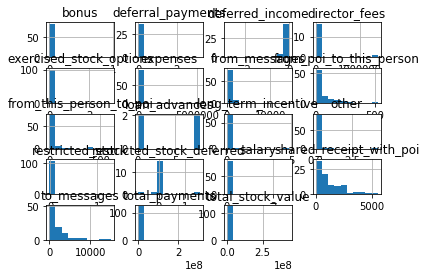

In [199]:
import matplotlib.pyplot as plt
plt.figure()
enron[float_features].hist()
plt.show()

In [200]:
# for all float features
# fill the empty slots with zeros
for col in float_features:
    enron[col] = enron[col].fillna(0)

In [201]:
enron_train[float_features].describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,6.100000e+01,2.800000e+01,3.400000e+01,13.000000,8.100000e+01,73.000000,65.000000,65.000000,65.000000,2.000000e+00,4.900000e+01,6.900000e+01,8.200000e+01,10.000000,7.300000e+01,65.000000,65.000000,9.600000e+01,9.800000e+01
mean,1.147436e+06,6.344374e+05,-4.625664e+05,89397.846154,2.985081e+06,51040.547945,711.323077,64.800000,40.092308,4.096250e+07,7.926171e+05,4.471774e+05,1.294855e+06,-221885.700000,2.739025e+05,1111.369231,2156.061538,2.590977e+06,3.527136e+06
std,1.505189e+06,8.603646e+05,8.095392e+05,41143.391399,6.004174e+06,47596.682104,2074.497628,91.863214,88.901407,5.736404e+07,9.504645e+05,1.341564e+06,2.498335e+06,205191.374121,1.716647e+05,1165.852016,2811.676718,1.056645e+07,7.182997e+06
min,7.000000e+04,-1.025000e+05,-3.504386e+06,3285.000000,3.285000e+03,148.000000,12.000000,0.000000,0.000000,4.000000e+05,7.102300e+04,2.000000e+00,4.409300e+04,-560222.000000,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,4.500000e+05,7.656750e+04,-5.527032e+05,101250.000000,4.004780e+05,18834.000000,19.000000,10.000000,0.000000,2.068125e+07,2.750000e+05,9.720000e+02,2.689220e+05,-389621.750000,2.061210e+05,178.000000,517.000000,3.024025e+05,4.211518e+05
50%,7.500000e+05,1.951900e+05,-1.175340e+05,108579.000000,8.500100e+05,41953.000000,45.000000,28.000000,7.000000,4.096250e+07,4.221580e+05,5.238200e+04,4.628225e+05,-139856.500000,2.516540e+05,599.000000,1088.000000,1.106740e+06,9.979710e+05
75%,1.000000e+06,8.342052e+05,-2.708325e+04,112492.000000,2.165172e+06,59175.000000,215.000000,88.000000,27.000000,6.124375e+07,8.318090e+05,3.620960e+05,9.664905e+05,-77953.250000,2.885890e+05,1902.000000,2649.000000,1.985668e+06,2.493616e+06
max,8.000000e+06,2.964506e+06,-1.042000e+03,125034.000000,3.434838e+07,228763.000000,14368.000000,528.000000,411.000000,8.152500e+07,5.145434e+06,1.035973e+07,1.476169e+07,44093.000000,1.111258e+06,4527.000000,15149.000000,1.035598e+08,4.911008e+07


<Figure size 432x288 with 0 Axes>

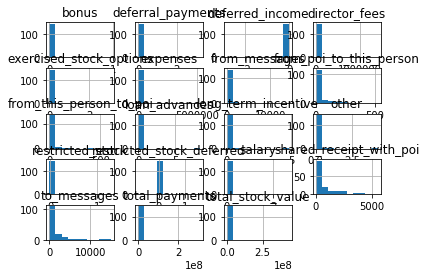

In [202]:
plt.figure()
enron[float_features].hist()
plt.show()

In [203]:
na_check(enron)

,Missing Ratio
email_address,23.972603


In [204]:
# so, drop names and email addresses
enron = enron.drop(['name', 'email_address'] , axis=1)
enron.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,0.0,-3504386.0,0.0,19794175.0,46950.0,18.0,42.0,4.0,0.0,1617011.0,174839.0,2748364.0,0.0,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,0.0,0.0,0.0,19250000.0,29336.0,108.0,88.0,30.0,0.0,1920000.0,22122.0,6843672.0,0.0,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,0.0,-4167.0,0.0,1624396.0,22884.0,39.0,13.0,14.0,0.0,0.0,1573324.0,869220.0,0.0,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,0.0,0.0,0.0,0.0,118134.0,0.0,0.0,0.0,0.0,602671.0,907502.0,985032.0,0.0,224305.0,0.0,0.0,2652612.0,985032.0
4,1250000.0,0.0,-262500.0,0.0,0.0,35818.0,144.0,199.0,25.0,0.0,375304.0,486.0,126027.0,0.0,240189.0,2188.0,2598.0,1639297.0,126027.0


In [205]:
# 將前述轉換完畢資料 enron , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = enron[:train_num]
test_X = enron[train_num:]
# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
lr = LogisticRegression()
gdbt = GradientBoostingClassifier()
rf = RandomForestClassifier()


In [206]:
# 線性迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準, 以下模型同理)
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': name, 'poi': lr_pred})
sub.to_csv('enron_lr.csv', index=False)
ls_score=lr.score(train_X,train_Y)
print(ls_score)

0.8761061946902655


In [207]:
# 梯度提升機預測檔 
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': name, 'poi': gdbt_pred})
sub.to_csv('enron_gdbt.csv', index=False)
gdbt_score=gdbt.score(train_X,train_Y)
print(gdbt_score)

1.0


In [208]:
# 隨機森林預測檔
rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=6, bootstrap=True)
rf.fit(train_X, train_Y)
rf_pred = rf.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': name, 'poi': rf_pred})
sub.to_csv('enron_rf.csv', index=False)
rf_score=rf.score(train_X,train_Y)
print(rf_score)

1.0


In [209]:
# 混合泛化預測檔 
"""
Your Code Here
"""
ls_score=(ls_score*100)**30
gdbt_score=(gdbt_score*100)**30
rf_score=(rf_score*100)**30

ls_ratio=(ls_score)/(ls_score+gdbt_score+rf_score)
gdbt_ratio=(gdbt_score)/(ls_score+gdbt_score+rf_score)
rf_ratio=(rf_score)/(ls_score+gdbt_score+rf_score)
print(ls_ratio)
print(gdbt_ratio)
print(rf_ratio)

blending_pred = lr_pred*ls_ratio  + gdbt_pred*gdbt_ratio + rf_pred*rf_ratio
sub = pd.DataFrame({'name': name, 'poi':blending_pred})
sub.to_csv('enron_blending.csv', index=False)


0.009366675422864032
0.495316662288568
0.495316662288568


In [210]:
from mlxtend.classifier import StackingClassifier

meta_estimator = GradientBoostingClassifier(tol=100, subsample=0.70, n_estimators=50, 
                                           max_features='sqrt', max_depth=4, learning_rate=0.3)
"""
Your Code Here
"""
stacking = StackingClassifier(classifiers=[lr, gdbt, rf], meta_classifier=meta_estimator)


In [211]:
stacking.fit(train_X, train_Y)
stacking_pred = stacking.predict(test_X)
sub = pd.DataFrame({'name': name, 'poi': stacking_pred})
sub.to_csv('enron_stacking.csv', index=False)